# Computing Correlations
@author: Ofer Shir, oshir@alumni.Princeton.EDU

## Naive attempt: setting $\sigma$ and inferring $S$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.stats import multivariate_normal
import EntropyEstimation as EE
import rotateUncorrelatedZ as R
def expected_l1_norm_rounded_monte_carlo(mu=0, sigma=1, n=1, num_samples=10000) :
    # l1_norms = []
    # for _ in range(num_samples) :
    #     samples = np.random.normal(mean, std, n).round().astype(int)
    #     l1_norms.append(np.sum(np.abs(samples)))
    #     return np.mean(l1_norms)
    random_variables = np.random.normal(mu, sigma, (num_samples, n))
    rounded_variables = np.round(random_variables)
    l1_norms = np.sum(np.abs(rounded_variables), axis=1)
    return np.mean(l1_norms)
#sigma_values = [0.5, 2, 5, 10]
#S_values = [expected_l1_norm_rounded_monte_carlo(mu=0, sigma=s) for s in sigma_values]
ee = True
num_samples = 10000  # Number of samples
nz = 2 #np.sqrt(2) #dimension
# Define a range of positive and negative correlation values
# correlation_values = [-0.8, -0.0, 0.8, 1.2]  # Negative and positive correlations included
correlation_values = np.array([0.0]) #np.array([0.0, -0.8, 0.8, 1.2])
c11,c22 = 1.0, 2.0 #1.441
angles = 0.5 * np.arctan(2 * correlation_values / (c11 - c22))  # 
#mu = np.array([0., 0.])
S_values = np.array([1, 2, 3, 4, 5, 6]) #2.0*(1.0-p_values)/(p_values*(2-p_values))
for i, corr in enumerate(correlation_values):
#for i, corr in enumerate(S_values) :
    Sigma = np.array([[ c11**2 , corr], [corr,  c22**2]])
    # Sigma = cov_to_scaled_matrix(Sigma0)
    eigenvalues, eigenvectors = np.linalg.eig(Sigma)
    D = np.diag(eigenvalues)
    print("Defining Covariance Matrix:")
    print(Sigma)
    print(D)
    s11 = np.sqrt(D[0,0])
    s22 = np.sqrt(D[1,1])
    S1 = expected_l1_norm_rounded_monte_carlo(mu=0, sigma=s11)   #1*np.sqrt(2.0/(np.pi))*c11 #(c11/nz) with nz=np.sqrt(2)
    S2 = expected_l1_norm_rounded_monte_carlo(mu=0, sigma=s22)   #1*np.sqrt(2.0/(np.pi))*c22 #(c22/nz) with nz=np.sqrt(2)
    # Set parameters for the geometric distributions - following the transformation S==>p per S=1.0 and n=2
    p1 = 1.0 - ( S1 / (1.0+np.sqrt(1+(S1**2))) )
    p2 = 1.0 - ( S2 / (1.0+np.sqrt(1+(S2**2))) )
    # Generate independent geometric samples Z11, Z12, Z21, and Z22
    # c12 = corr #0.5 * (sigma1**2 - sigma2**2) * np.tan(2 * alpha12[0])
    theta = np.array([0.5 * np.arctan(2 * corr / (c11 - c22))])
    DG_samples = R.generatePopulation_2D_DG(p1=p1, p2=p2, alpha12=theta)

    normal_samples = R.generatePopulation_2D_TN(sigma1=c11, sigma2=c22, alpha12=theta) #np.random.multivariate_normal([0, 0], Sigma , num_samples ) #[[c11, corr], [corr, c22]]
        
    empirical_cov_TN = np.cov(np.round(normal_samples), rowvar=False)
    empirical_cov_DG = np.cov(DG_samples, rowvar=False) #cov_to_scaled_matrix(
    
    
    print("\nEmpirical TN Covariance Matrix:")
    print(empirical_cov_TN)

    # # Compare the matrices
    # print("\nDifference between TN Covariance Matrices:")
    # print(Sigma - empirical_cov_TN)
    
    print("\nEmpirical DG Covariance Matrix:")
    print(empirical_cov_DG)

    # # Compare the matrices
    # print("\nDifference between DG Covariance Matrices:")
    # print(Sigma - empirical_cov_DG)
    
    # correlation_coefficient = np.corrcoef(X1_correlated, X2_correlated)[0, 1]
    # spearman_correlation_coefficient = spearmanr(X1_correlated, X2_correlated)[0]
    # print("Pearson Correlation:", correlation_coefficient, ";  Spearman:", spearman_correlation_coefficient)

    if ee :
        print("TN: ")
        EE.estimateEntropy(np.round(normal_samples))
        print("DG: ")
        EE.estimateEntropy(DG_samples)


Defining Covariance Matrix:
[[1. 0.]
 [0. 4.]]
[[1. 0.]
 [0. 4.]]

Empirical TN Covariance Matrix:
[[ 1.1075722  -0.03212705]
 [-0.03212705  4.11790203]]

Empirical DG Covariance Matrix:
[[ 1.58502950e+00 -2.60526053e-03]
 [-2.60526053e-03  5.52512751e+00]]
TN: 
Multivariate histogram-based entropy estimate: 5.1794 bits
DG: 
Multivariate histogram-based entropy estimate: 4.7947 bits


## The right way: $S \leadsto \sigma$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.stats import multivariate_normal
import EntropyEstimation as EE
import rotateUncorrelatedZ as R
import L1correlation as L1
ee = False
num_samples = 100000  # Number of samples
nz = 2 #np.sqrt(2) #dimension
# Define a range of positive and negative correlation values
# correlation_values = [-0.8, -0.0, 0.8, 1.2]  # Negative and positive correlations included
# correlation_values = np.array([0.0]) #np.array([0.0, -0.8, 0.8, 1.2])
# c11,c22 = 1.0, 2.0 #1.441
# angles = 0.5 * np.arctan(2 * correlation_values / (c11 - c22))  # 
#mu = np.array([0., 0.])
S_values = np.array([1, 2, 3, 4, 5, 6]) #2.0*(1.0-p_values)/(p_values*(2-p_values))
theta_values = np.array([0.0,0.1,0.2,0.3])
#for i, corr in enumerate(correlation_values):
for i, S2 in enumerate(S_values) : #<======= iterate over S_values
#for i, t in enumerate(theta_values) : 
    #theta=np.array([t])
    theta = np.array([0.0]) #np.array([0.5 * np.arctan(2 * corr / (c11 - c22))])
    S1 = 1
 #   S2 = 2    #s22 = S2
    print(f"\n * * * S1={S1}, S2={S2}, alpha12={theta} * * *")
    c11 = np.sqrt(np.pi/2) * S1/1
    c22 = np.sqrt(np.pi/2) * S2/1
    # corr = 0.5 * (c11**2 - c22**2) * np.tan(2 * theta[0])
    # Sigma = np.array([[ c11**2 , corr], [corr,  c22**2]])
    corrS = 0.5 * (S1**2 - S2**2) * np.tan(2 * theta[0])
    SigmaS = np.array([[ S1 , corrS], [corrS,  S2]])
    print("Defining Covariance Matrix:")
    print(SigmaS)
    print("\n")
    #S1 = expected_l1_norm_rounded_monte_carlo(mu=0, sigma=s11)   #1*np.sqrt(2.0/(np.pi))*c11 #(c11/nz) with nz=np.sqrt(2)
    #S2 = expected_l1_norm_rounded_monte_carlo(mu=0, sigma=s22)   #1*np.sqrt(2.0/(np.pi))*c22 #(c22/nz) with nz=np.sqrt(2)
    # Set parameters for the geometric distributions - following the transformation S==>p per S=1.0 and n=2
    p1 = 1.0 - ( (S1/1) / (1.0+np.sqrt(1+((S1/1)**2))) )
    p2 = 1.0 - ( (S2/1) / (1.0+np.sqrt(1+((S2/1)**2))) )

    # Generate independent geometric samples Z11, Z12, Z21, and Z22
    # c12 = corr #0.5 * (sigma1**2 - sigma2**2) * np.tan(2 * alpha12[0])
    DG_samples = R.generatePopulation_2D_DG(p1=p1, p2=p2, alpha12=theta, num_samples=num_samples)
    R.analyzeSampledPopulation2D(DG_samples, "DG")
    L1.sophisticatedL1correlation(DG_samples, "DG/")
    print("=============================\n")
    #
    TN_samples = R.generatePopulation_2D_TN(sigma1=c11, sigma2=c22, alpha12=theta, num_samples=num_samples) #np.random.multivariate_normal([0, 0], Sigma , num_samples ) #[[c11, corr], [corr, c22]]
    R.analyzeSampledPopulation2D(TN_samples, "TN")
    L1.sophisticatedL1correlation(TN_samples, "TN/")
    print("=============================\n")
    #
    # normal_samples = np.round(np.random.multivariate_normal([0, 0], Sigma , num_samples ))
    # R.analyzeSampledPopulation2D(normal_samples, "multivariateNormal")
    # #
    
    if ee :
        print("TN: ")
        EE.estimateEntropy(TN_samples)
        print("DG: ")
        EE.estimateEntropy(DG_samples)

## Computing correlations when rotating in certain angles

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rotateUncorrelatedZ as R
from scipy.stats import multivariate_normal
import angles2cov as AC
import L1correlation as L1
num_samples = 100000  # Number of samples
#
#theta_values = np.array([0.0,np.pi/8,np.pi/4,np.pi/2])
theta_values = np.array([0.0,0.1,0.2,0.3])
# theta_labels = ["$0.0$","$\pi/8$","$\pi/4$","$\pi/2$"]

S1 = 1.0 #1*np.sqrt(2.0/(np.pi))*c11 #(c11/nz) with nz=np.sqrt(2)
S2 = 3.0 #1*np.sqrt(2.0/(np.pi))*c22 #(c22/nz) with nz=np.sqrt(2)
# Set parameters for the geometric distributions - following the transformation S==>p per S=1.0 and n=2
p1 = 1.0 - ( (S1/1) / (1.0+np.sqrt(1+((S1/1)**2))) )
p2 = 1.0 - ( (S2/1) / (1.0+np.sqrt(1+((S2/1)**2))) )
#
c11 = np.sqrt(np.pi/2) * S1/1
c22 = np.sqrt(np.pi/2) * S2/1
#
mu = np.array([0., 0.])
lowerB,upperB = -10,10
step = 0.05
x = np.arange(lowerB, upperB+step, step)
y = np.arange(lowerB, upperB+step, step)
xx, yy = np.meshgrid(x, y)
# Pack X and Y into a single 3-dimensional array
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx
pos[:, :, 1] = yy
for i, t in enumerate(theta_values):
    theta = np.array([t])
    print(f"***** theta={t} *****\n")
    DG_samples = R.generatePopulation_2D_DG(p1=p1, p2=p2, alpha12=theta)
    R.analyzeSampledPopulation2D(DG_samples, "DG")
    L1.sophisticatedL1correlation(DG_samples, "DG/")
    print("=============================\n")
    #
    TN_samples = R.generatePopulation_2D_TN(sigma1=c11, sigma2=c22, alpha12=theta, num_samples=num_samples) #np.random.multivariate_normal([0, 0], Sigma , num_samples ) #[[c11, corr], [corr, c22]]
    R.analyzeSampledPopulation2D(TN_samples, "TN")
    L1.sophisticatedL1correlation(TN_samples, "TN/")
    print("=============================\n")
    #
    if t>0 :
        corr = 0.5 * (c11**2 - c22**2) * np.tan(2*t)
    else:
        corr = 0.0
    Sigma0 = np.array([[ c11**2 , corr], [corr,  c22**2]])
    Sigma = AC.enforce_symmetry_and_psd(Sigma0)
    print(Sigma0)
    print(Sigma)
    F = multivariate_normal(mu, Sigma)
    Z = F.pdf(pos)
    normal_samples = np.round(np.random.multivariate_normal([0, 0], Sigma , num_samples ))
    R.analyzeSampledPopulation2D(normal_samples, "Normal")  

## Computing the $\ell_1$-norm for the rotated samples per $\theta \in [0,\pi/2]$

Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-positive definite matrix. Returning zero.
Caught a singular, non-po

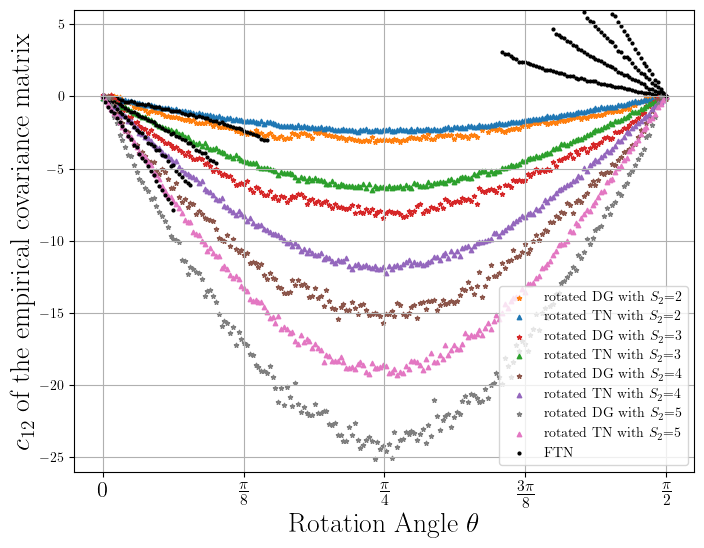

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import rotateUncorrelatedZ as R
from scipy.stats import multivariate_normal
import angles2cov as AC
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import force2Dcov as FC
num_samples = 10000  # Number of samples
#
def targetMeasure0(data) :
    l1_norms = np.sum(np.abs(data), axis=1)    
    empirical_expected_l1_norm = np.mean(l1_norms)
    return empirical_expected_l1_norm
# 
def targetMeasure1(data) :
    X = data[:,0]
    Y = data[:,1]
    scaler = StandardScaler()
    X_scaled = X.reshape(-1, 1)  # Ensure X is a 2D array
    Y_scaled = Y.reshape(-1, 1)  # Ensure Y is a 2D array
    X_scaled = scaler.fit_transform(X_scaled)
    Y_scaled = scaler.fit_transform(Y_scaled)
    # Fit a Lasso regression model to predict Y from X
    lasso = Lasso(alpha=0.1)  # L1 regularization strength 
    lasso.fit(X_scaled, Y_scaled)
    l1_norm_coefs = np.sum(np.abs(lasso.coef_))
    # return l1_norm_coefs / (np.mean(np.abs(X_scaled)) * np.mean(np.abs(Y_scaled)))
    # X_range = np.max(np.abs(X_scaled)) - np.min(np.abs(X_scaled))
    # Y_range = np.max(np.abs(Y_scaled)) - np.min(np.abs(Y_scaled))
    # return l1_norm_coefs / (X_range * Y_range)
    # The L1-norm of the coefficients gives us an idea of the relationship strength
    return l1_norm_coefs  # sum of the absolute values of the coefficients 
    # model = sm.OLS(Y_scaled, sm.add_constant(X_scaled)).fit()
    # return model.rsquared
# 
def targetMeasure2(data) :
    X = data[:, 0]
    Y = data[:, 1]
    # Scale the data
    scaler = StandardScaler()
    X_scaled = X.reshape(-1, 1)  # Ensure X is a 2D array
    Y_scaled = Y.reshape(-1, 1)  # Ensure Y is a 2D array
    X_scaled = scaler.fit_transform(X_scaled)
    Y_scaled = scaler.fit_transform(Y_scaled)
    pearson_corr, _ = pearsonr(np.abs(X_scaled), np.abs(Y_scaled))
    return (1 + pearson_corr) / 2
def targetMeasure(data) :
    # X = data[:, 0]
    # Y = data[:, 1]
    # # Scale the data
    # scaler = StandardScaler()
    # X_scaled = X.reshape(-1, 1)  # Ensure X is a 2D array
    # Y_scaled = Y.reshape(-1, 1)  # Ensure Y is a 2D array
    # X_scaled = scaler.fit_transform(X_scaled)
    # Y_scaled = scaler.fit_transform(Y_scaled)
    # stacked_data = np.hstack((X_scaled, Y_scaled))
    # empirical_cov = np.cov(stacked_data, rowvar=False) 
    empirical_cov = np.cov((data), rowvar=False) 
    return empirical_cov[0,1]
#theta_values = np.array([0.0,np.pi/8,np.pi/4,np.pi/2])
#theta_values = np.array([0.0,0.1,0.2,0.3])
theta_values = np.linspace(0.0, 0.5*np.pi, 200)
# theta_labels = ["$0.0$","$\pi/8$","$\pi/4$","$\pi/2$"]
S1 = 1.0 #1*np.sqrt(2.0/(np.pi))*c11 #(c11/nz) with nz=np.sqrt(2)
p1 = 1.0 - ( (S1/1) / (1.0+np.sqrt(1+((S1/1)**2))) )
c11 = np.sqrt(np.pi/2) * S1/1
S_values = [2,3,4,5]
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
# Loop over different values of S
for idx, S in enumerate(S_values):
    # title = f'sigma-vs-S_N{n}'
    nDG,nTN = np.zeros_like(theta_values),np.zeros_like(theta_values)
    nRN = np.zeros_like(theta_values) #,np.zeros_like(theta_values)

    S2 = S
    p2 = 1.0 - ( (S2/1) / (1.0+np.sqrt(1+((S2/1)**2))) )
    c22 = np.sqrt(np.pi/2) * S2/1

    for i, t in enumerate(theta_values):
        theta = np.array([t])
        DG_samples = R.generatePopulation_2D_DG(p1=p1, p2=p2, alpha12=theta)
        nDG[i] = targetMeasure(DG_samples)    
    #
        TN_samples = R.generatePopulation_2D_TN(sigma1=c11, sigma2=c22, alpha12=theta, num_samples=num_samples) 
        nTN[i] = targetMeasure(TN_samples)
    #
        Sigma = FC.force2Dcovariance(S1=S1,S2=S2,alpha12=t)
        if np.trace(Sigma) > 0 :
            rounded_normal_samples = np.round(np.random.multivariate_normal([0, 0], Sigma , num_samples ))
            nRN[i] = targetMeasure(rounded_normal_samples)
        else :
            nRN[i] = -100

        # if t>0 :
        #     corr = 0.5 * (c11**2 - c22**2) * np.tan(2*t)
        # else:
        #     corr = 0.0
        # Sigma0 = np.array([[ c11**2 , corr], [corr,  c22**2]])
        # Sigma = AC.enforce_symmetry_and_psd(Sigma0)
        # try:
        #     F = multivariate_normal(mu, Sigma)
        #     Z = F.pdf(pos)
        #     # normal_samples = np.random.multivariate_normal([0, 0], Sigma , num_samples )
        #     # nNN[i] = np.mean(np.sum(np.abs(normal_samples), axis=1))
        #     rounded_normal_samples = np.round(np.random.multivariate_normal([0, 0], Sigma , num_samples ))
        #     nRN[i] = targetMeasure(rounded_normal_samples)
        # except np.linalg.LinAlgError as e:
        #     if "singular" in str(e).lower() and "positive definite" in str(e).lower():
        #         print("Caught a singular, non-positive definite matrix. Returning zero.")
        #         nNN[i] = -1
        #         nRN[i] = -1
        #     else:
        #         # Re-raise the exception if it's a different LinAlgError
        #         raise
#

    plt.scatter(theta_values, nDG, label=f"rotated DG with $S_2$={S}",marker='*', color=colors[2*idx+1], s=10)
    plt.scatter(theta_values, nTN, label=f"rotated TN with $S_2$={S}",marker='^', color=colors[2*idx], s=10)
# plt.scatter(theta_values, nNN, label='Multivariate Normal with $S_2=2.0$',color='tab:green', marker='*', s=50)
    if idx>2 :
        plt.scatter(theta_values, nRN, label='FTN',color='black', marker='o',s=4)
    else:
        plt.scatter(theta_values, nRN, color='black', marker='o',s=4)
plt.rc('text',usetex=True)
plt.rc('font',family='serif')
plt.xlabel(r"Rotation Angle $\theta$",fontsize=20) # plt.xlabel(r"$\sigma$",fontsize=20)
# plt.ylabel(r"Expected $\ell_1$-norm",fontsize=20)
# plt.ylabel(r"$\ell_1$ correlation via LASSO",fontsize=20)
plt.ylabel(r"$c_{12}$ of the empirical covariance matrix",fontsize=20)
# Set x-ticks at fractions of pi
tick_positions = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
tick_labels = ['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$']
# Add the x-ticks
plt.xticks(tick_positions, tick_labels,fontsize=16)
# plt.title('Entropy of Truncated Gaussian Distribution vs. $\\sigma$')
plt.grid(True)
# plt.ylim(2.5,10)
plt.ylim(-26,6)
# plt.ylim(-0.5,13)
plt.legend()
# plt.savefig("entropy2DCorrelated.svg",format='svg')
plt.show()
     